In [36]:
import json
import numpy as np
import librosa
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model("finetuned_cnn_model.h5")

# Load label mapping
with open("label_mapping.json", "r") as f:
    label_mapping = json.load(f)

# Reverse mapping: index → label
idx_to_label = {v: k for k, v in label_mapping.items()}

print("Loaded classes in correct order:")
print(idx_to_label)


Loaded classes in correct order:
{0: 'Accordion', 1: 'Alto Saxophone', 2: 'Bass Tuba', 3: 'Bassoon', 4: 'Cello', 5: 'Clarinet in Bb', 6: 'Contrabass', 7: 'Flute', 8: 'French Horn', 9: 'Oboe', 10: 'Trombone', 11: 'Trumpet in C', 12: 'Viola', 13: 'Violin'}


In [49]:
AUDIO_PATH = "test_audio/basstuba.wav"   # 👈 INPUT AUDIO FILE HERE
TARGET_SR = 22050


In [50]:
def load_audio(audio_path, target_sr=TARGET_SR):
    audio, sr = librosa.load(
        audio_path,
        sr=target_sr,
        mono=True
    )
    return audio, sr

audio, sr = load_audio(AUDIO_PATH)
print("Audio loaded | Sample rate:", sr)



Audio loaded | Sample rate: 22050


In [51]:
IMG_SIZE = (224, 224)

def preprocess_audio(audio, sr):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=128
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

    # Resize to CNN input size
    mel_db = tf.image.resize(mel_db[..., np.newaxis], IMG_SIZE)
    mel_db = np.repeat(mel_db, 3, axis=-1)  # 3 channels

    return np.expand_dims(mel_db, axis=0)


In [52]:
mel_input = preprocess_audio(audio, sr)

probs = model.predict(mel_input)[0]
print("Raw probabilities:", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Raw probabilities: [1.55930058e-03 4.74028336e-03 3.84229869e-01 1.98644232e-02
 1.55528575e-01 5.70609653e-03 5.98052256e-02 2.62731174e-03
 2.56984640e-04 2.99959444e-03 1.26061102e-04 1.21211546e-04
 9.79975099e-04 6.54574658e-04]


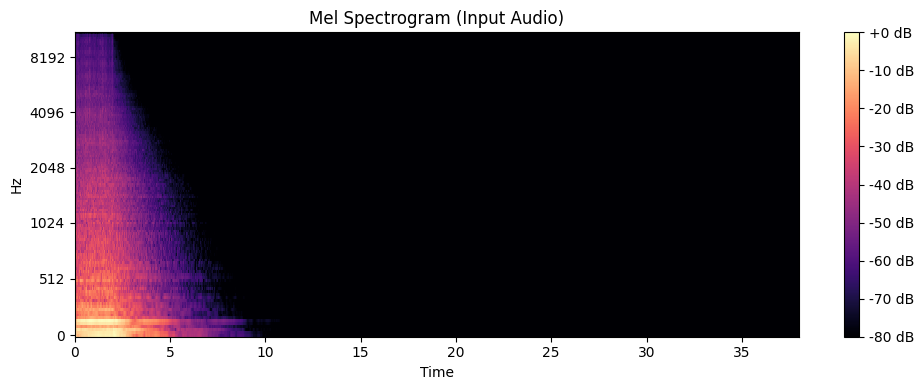

In [53]:
import matplotlib.pyplot as plt
import librosa.display

def show_mel_spectrogram(audio, sr):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=128
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        mel_db,
        sr=sr,
        x_axis="time",
        y_axis="mel"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram (Input Audio)")
    plt.tight_layout()
    plt.show()
show_mel_spectrogram(audio, sr)


In [54]:
# Get top 5 predictions
top5_idx = np.argsort(probs)[::-1][:5]

print("\nTop 5 Predicted Instruments:")
for i in top5_idx:
    print(f"{idx_to_label[i]} : {probs[i]*100:.2f}%")



Top 5 Predicted Instruments:
Bass Tuba : 38.42%
Cello : 15.55%
Contrabass : 5.98%
Bassoon : 1.99%
Clarinet in Bb : 0.57%
